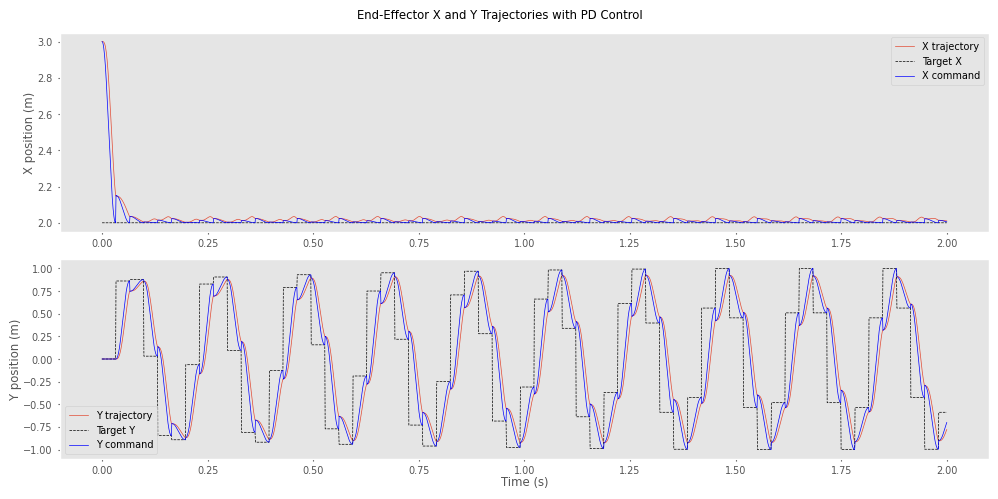

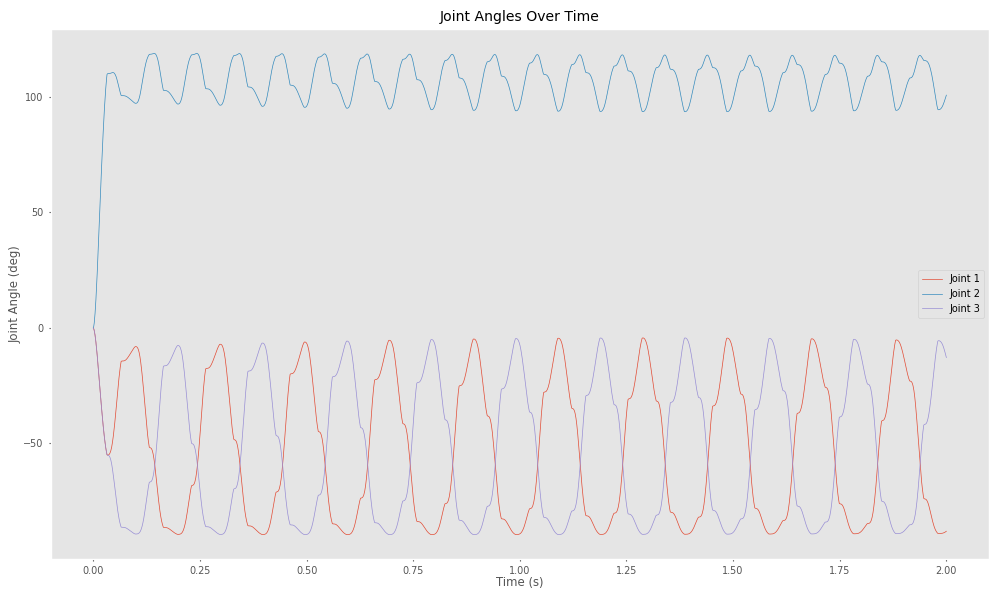

In [73]:
import numpy as np
import matplotlib.pyplot as plt
from roboticstoolbox import DHRobot, RevoluteDH
import roboticstoolbox as rtb
from spatialmath import SE3

# robot parameters
m = 1.0
L = 1.0

joint_lim = np.deg2rad(np.array([-135, 135]))
robot = DHRobot([
    RevoluteDH(a=L, alpha=0, d=0, m=m, r=[L, 0, 0], I=[0]*6, qlim=joint_lim),
    RevoluteDH(a=L, alpha=0, d=0, m=m, r=[L, 0, 0], I=[0]*6, qlim=joint_lim),
    RevoluteDH(a=L, alpha=0, d=0, m=m, r=[L, 0, 0], I=[0]*6, qlim=joint_lim)
], gravity=[0, -9.81, 0], name='PlanarRRR')

trajectory_freq = 30    # Hz
control_freq = 1000     # Hz
T_total = 2             # seconds

dt_traj = 1 / trajectory_freq
dt_ctrl = 1 / control_freq

steps = int(T_total / dt_ctrl)
traj_update_steps = int(control_freq / trajectory_freq)

Kp = np.diag([80000.0] * 3)             # proportional gain
Kd = 2*np.sqrt(Kp)                    # derivative gain

# joint angles
q_current = np.zeros(3)
q_dot = np.zeros(3)
q_ddot = np.zeros(3)

q_target = np.zeros(3)
q_dot_target = np.zeros(3)

# log joint angles, position and target
q_log = []
xy_log = []
target_log = []
command_log = []

current_T = robot.fkine(q_current)
traj_start_x = current_T.x
traj_start_y = current_T.y


traj_idx = 0

# time loop
for i in range(steps):
    t = i * dt_ctrl     # calculate current time

    # every 1/30 s
    if i % traj_update_steps == 0:
        current_T = robot.fkine(q_current)          # recalculate the current pose

        traj_start_x = current_T.x
        traj_start_y = current_T.y


        # get new goal
        target_x = 2 * L                                   
        target_y = L * np.sin(2 * np.pi * 5 * t)

        # trajectory planning for x and y
        trajx = rtb.trapezoidal(traj_start_x, target_x, traj_update_steps)
        trajy = rtb.trapezoidal(traj_start_y, target_y, traj_update_steps)

        traj_idx = -1
    
    # construct next position
    traj_idx += 1
    x_des = trajx.q[traj_idx]
    y_des = trajy.q[traj_idx]
    next_T = SE3(x_des, y_des, 0)

    # inverse kinematics
    q_sol, success, *_ = robot.ik_NR(next_T, q0=q_current)

    if success:
        q_target = q_sol
    else:
        print(f"IK failed at t = {t:.3f}s")

    error = q_current - q_target
    control = -Kd @ q_dot - Kp @ error

    M = robot.inertia(q_current)
    V = robot.coriolis(q_current, q_dot)
    G = robot.gravload(q_current)
    # compute torque
    tau = M @ control + V @ q_dot + G

    # compute acceleration due to torque
    q_ddot = robot.accel(q_current, q_dot, tau)

    # integrate to get current q and q dot
    q_dot += q_ddot * dt_ctrl
    q_current += q_dot * dt_ctrl + 0.5 * q_ddot * dt_ctrl**2

    q_log.append(q_current.copy())
    xy_log.append(robot.fkine(q_current).t[:2])
    command_log.append([x_des, y_des])
    target_log.append([target_x, target_y])

q_log = np.rad2deg(np.array(q_log))
xy_log = np.array(xy_log)
command_log = np.array(command_log)
target_log = np.array(target_log)
t_log = np.linspace(0, T_total, steps)
target_t_log = np.linspace(0, T_total, len(target_log))

plt.figure(figsize=(10, 5))

# X trajectory
plt.subplot(2, 1, 1)
plt.plot(t_log, xy_log[:, 0], label='X trajectory')
plt.plot(target_t_log, target_log[:, 0], 'k--', label='Target X')
plt.plot(t_log, command_log[:, 0],"b", label='X command')
plt.ylabel('X position (m)')
plt.legend()
plt.grid()

# Y trajectory
plt.subplot(2, 1, 2)
plt.plot(t_log, xy_log[:, 1], label='Y trajectory')
plt.plot(target_t_log, target_log[:, 1], 'k--', label='Target Y')
plt.plot(t_log, command_log[:, 1], "b", label='Y command')
plt.xlabel('Time (s)')
plt.ylabel('Y position (m)')
plt.legend()
plt.grid()

plt.suptitle('End-Effector X and Y Trajectories with PD Control')
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(t_log, q_log[:, 0], label='Joint 1')
plt.plot(t_log, q_log[:, 1], label='Joint 2')
plt.plot(t_log, q_log[:, 2], label='Joint 3')
plt.xlabel('Time (s)')
plt.ylabel('Joint Angle (deg)')
plt.title('Joint Angles Over Time')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()


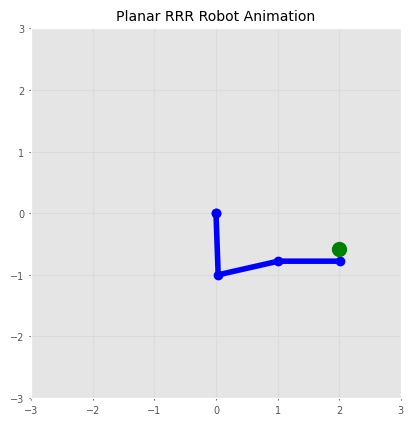

In [74]:
import matplotlib.animation as animation

# Create a new figure for the animation
fig, ax = plt.subplots()
ax.set_aspect('equal')
ax.set_xlim(-3*L, 3*L)
ax.set_ylim(-3*L, 3*L)
ax.set_title('Planar RRR Robot Animation')

# Plot robot links as a single Line2D object
line, = ax.plot([], [], 'o-', lw=4, color='blue')

# Plot the target position as a green dot
target_dot, = ax.plot([], [], 'go', markersize=10)
current_target_idx = 0

# Update function for animation
def update(frame):
    q = np.deg2rad(q_log[frame])
    T = robot.fkine_all(q)
    
    # Extract joint positions
    x = [0]
    y = [0]
    for Ti in T:
        pos = Ti.t
        x.append(pos[0])
        y.append(pos[1])
    
    line.set_data(x, y)

    target_pos = target_log[frame]
    target_dot.set_data([target_pos[0]], [target_pos[1]])

    return line,

# Create animation
ani = animation.FuncAnimation(
    fig, update, frames=len(q_log),
    interval=dt_ctrl*1000, blit=True, repeat=False
)

ani.save("rrr_robot_animation.gif", writer="pillow", fps=int(4 / dt_ctrl))


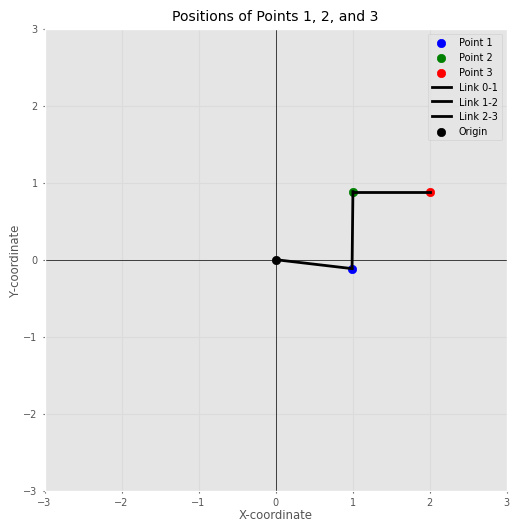

In [51]:
record_q = np.deg2rad(q_log[500])
x1 = L * np.cos(record_q[0])
y1 = L * np.sin(record_q[0])

x2 = x1 + L * np.cos(record_q[0] + record_q[1])
y2 = y1 + L * np.sin(record_q[0] + record_q[1])

x3 = x2 + L * np.cos(record_q[0] + record_q[1] + record_q[2])
y3 = y2 + L * np.sin(record_q[0] + record_q[1] + record_q[2])

# Plotting
plt.figure(figsize=(6, 6))

plt.xlim(-3*L, 3*L)
plt.ylim(-3*L, 3*L)

# Plot the points
plt.scatter(x1, y1, color='blue', label='Point 1')
plt.scatter(x2, y2, color='green', label='Point 2')
plt.scatter(x3, y3, color='red', label='Point 3')

# Connect the points
plt.plot([0, x1], [0, y1], color='black', linewidth=2, label='Link 0-1')
plt.plot([x1, x2], [y1, y2], color='black', linewidth=2, label='Link 1-2')
plt.plot([x2, x3], [y2, y3], color='black', linewidth=2, label='Link 2-3')

# Mark the origin
plt.scatter(0, 0, color='black', marker='o', label='Origin')

plt.xlabel('X-coordinate')
plt.ylabel('Y-coordinate')
plt.title('Positions of Points 1, 2, and 3')
plt.grid(True)
plt.legend()
plt.axhline(0, color='black', linewidth=0.5)
plt.axvline(0, color='black', linewidth=0.5)
plt.gca().set_aspect('equal', adjustable='box') # Ensure equal aspect ratio
plt.show()

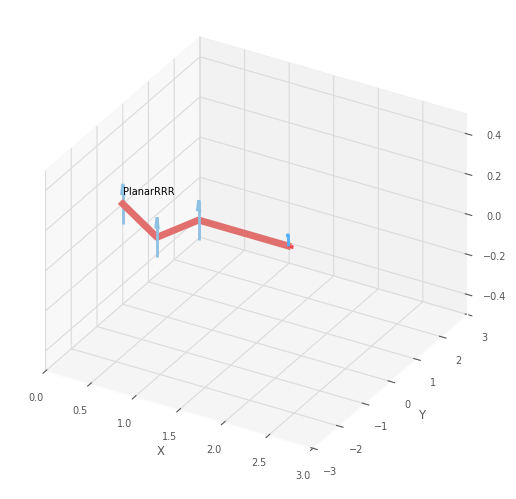

PyPlot3D backend, t = 0.05, scene:
  robot: Text(0.0, 0.0, 'PlanarRRR')

<Figure size 640x480 with 0 Axes>

In [49]:
robot.plot(q_log[300], limits=[0,3,-3,3,-0.5,0.5])

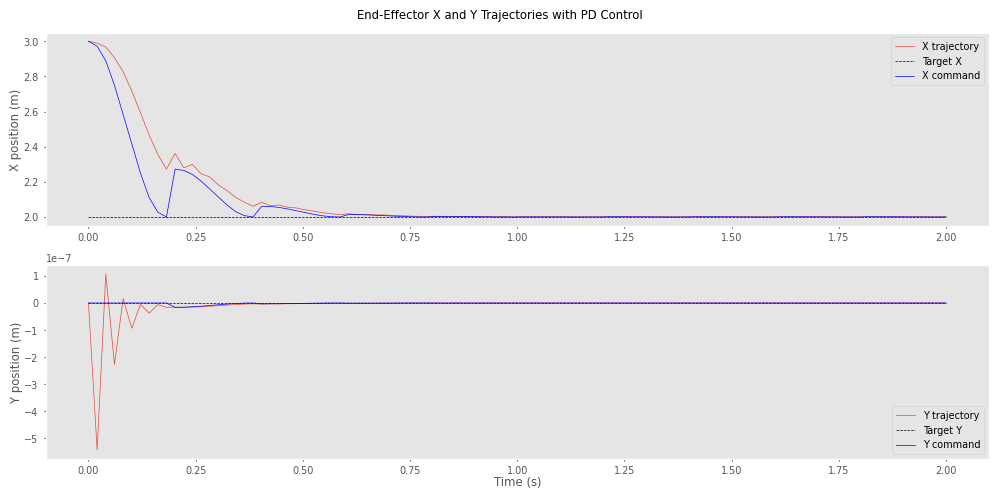

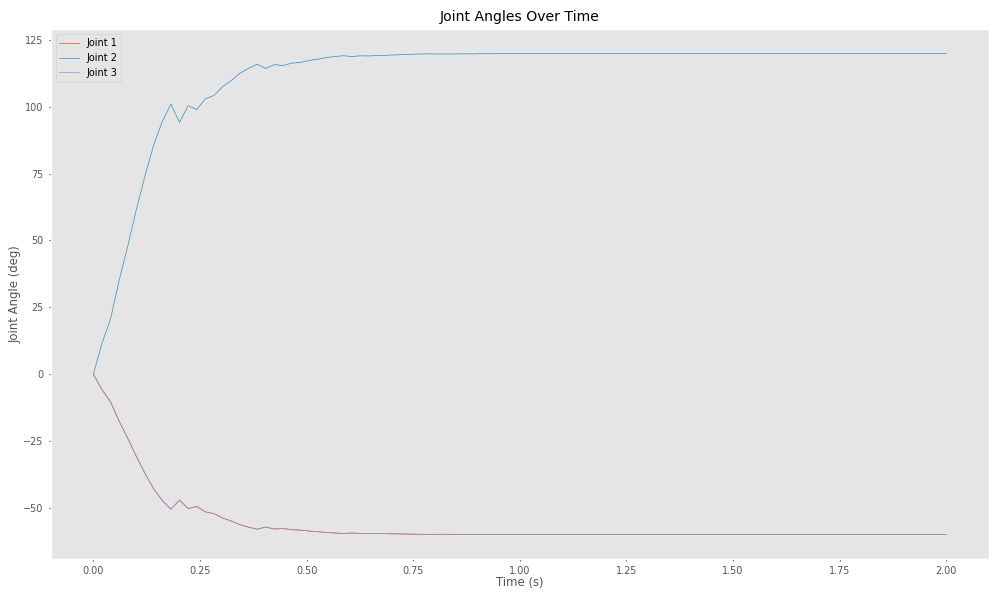

In [70]:
import numpy as np
import matplotlib.pyplot as plt
from roboticstoolbox import DHRobot, RevoluteDH
import roboticstoolbox as rtb
from spatialmath import SE3

# robot parameters
m = 1.0
L = 1.0
joint_lim = np.deg2rad(np.array([-160, 160]))
robot = DHRobot([
    RevoluteDH(a=L, alpha=0, d=0, m=m, r=[L, 0, 0], I=[0]*6, qlim=joint_lim),
    RevoluteDH(a=L, alpha=0, d=0, m=m, r=[L, 0, 0], I=[0]*6, qlim=joint_lim),
    RevoluteDH(a=L, alpha=0, d=0, m=m, r=[L, 0, 0], I=[0]*6, qlim=joint_lim)
], gravity=[0, -9.81, 0], name='PlanarRRR')

trajectory_freq = 5    # Hz
control_freq = 50      # Hz
T_total = 2            # seconds

dt_traj = 1 / trajectory_freq
dt_ctrl = 1 / control_freq

steps = int(T_total / dt_ctrl)
traj_update_steps = int(control_freq / trajectory_freq)

Kp = np.diag([1000.0] * 3)             # proportional gain
Kd = 2*np.sqrt(Kp)                    # derivative gain

# joint angles
q_current = np.zeros(3)
q_dot = np.zeros(3)
q_ddot = np.zeros(3)

q_target = np.zeros(3)
q_dot_target = np.zeros(3)

# log joint angles, position and target
q_log = []
xy_log = []
target_log = []
command_log = []

current_T = robot.fkine(q_current)
traj_start_x = current_T.x
traj_start_y = current_T.y


traj_idx = 0

# time loop
for i in range(steps):
    t = i * dt_ctrl     # calculate current time

    # every 1/30 s
    if i % traj_update_steps == 0:
        current_T = robot.fkine(q_current)          # recalculate the current pose

        traj_start_x = current_T.x
        traj_start_y = current_T.y


        # get new goal
        target_x = 2 * L                                   
        target_y = L * np.sin(2 * np.pi * 5 * t)

        # trajectory planning for x and y
        trajx = rtb.trapezoidal(traj_start_x, target_x, traj_update_steps)
        trajy = rtb.trapezoidal(traj_start_y, target_y, traj_update_steps)

        traj_idx = -1
    
    # construct next position
    traj_idx += 1
    x_des = trajx.q[traj_idx]
    y_des = trajy.q[traj_idx]
    next_T = SE3(x_des, y_des, 0)

    # inverse kinematics
    q_sol, success, *_ = robot.ik_NR(next_T, q0=q_current)

    if success:
        q_target = q_sol
    else:
        print(f"IK failed at t = {t:.3f}s")

    error = q_current - q_target
    control = -Kd @ q_dot - Kp @ error

    M = robot.inertia(q_current)
    V = robot.coriolis(q_current, q_dot)
    G = robot.gravload(q_current)
    # compute torque
    tau = M @ control + V @ q_dot + G

    # compute acceleration due to torque
    q_ddot = robot.accel(q_current, q_dot, tau)

    # integrate to get current q and q dot
    q_dot += q_ddot * dt_ctrl
    q_current += q_dot * dt_ctrl + 0.5 * q_ddot * dt_ctrl**2

    q_log.append(q_current.copy())
    xy_log.append(robot.fkine(q_current).t[:2])
    command_log.append([x_des, y_des])
    target_log.append([target_x, target_y])

q_log = np.rad2deg(np.array(q_log))
xy_log = np.array(xy_log)
command_log = np.array(command_log)
target_log = np.array(target_log)
t_log = np.linspace(0, T_total, steps)
target_t_log = np.linspace(0, T_total, len(target_log))

plt.figure(figsize=(10, 5))

# X trajectory
plt.subplot(2, 1, 1)
plt.plot(t_log, xy_log[:, 0], label='X trajectory')
plt.plot(target_t_log, target_log[:, 0], 'k--', label='Target X')
plt.plot(t_log, command_log[:, 0],"b", label='X command')
plt.ylabel('X position (m)')
plt.legend()
plt.grid()

# Y trajectory
plt.subplot(2, 1, 2)
plt.plot(t_log, xy_log[:, 1], label='Y trajectory')
plt.plot(target_t_log, target_log[:, 1], 'k--', label='Target Y')
plt.plot(t_log, command_log[:, 1], "b", label='Y command')
plt.xlabel('Time (s)')
plt.ylabel('Y position (m)')
plt.legend()
plt.grid()

plt.suptitle('End-Effector X and Y Trajectories with PD Control')
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(t_log, q_log[:, 0], label='Joint 1')
plt.plot(t_log, q_log[:, 1], label='Joint 2')
plt.plot(t_log, q_log[:, 2], label='Joint 3')
plt.xlabel('Time (s)')
plt.ylabel('Joint Angle (deg)')
plt.title('Joint Angles Over Time')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()


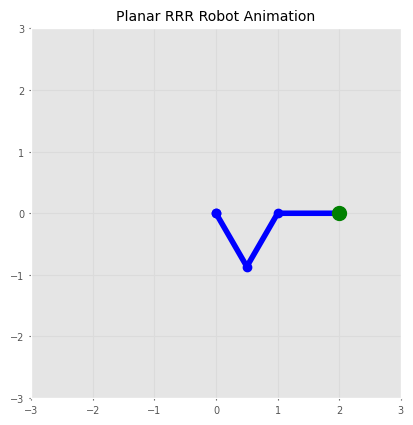

In [71]:
import matplotlib.animation as animation

# Create a new figure for the animation
fig, ax = plt.subplots()
ax.set_aspect('equal')
ax.set_xlim(-3*L, 3*L)
ax.set_ylim(-3*L, 3*L)
ax.set_title('Planar RRR Robot Animation')

# Plot robot links as a single Line2D object
line, = ax.plot([], [], 'o-', lw=4, color='blue')

# Plot the target position as a green dot
target_dot, = ax.plot([], [], 'go', markersize=10)
current_target_idx = 0

# Update function for animation
def update(frame):
    q = np.deg2rad(q_log[frame])
    T = robot.fkine_all(q)
    
    # Extract joint positions
    x = [0]
    y = [0]
    for Ti in T:
        pos = Ti.t
        x.append(pos[0])
        y.append(pos[1])
    
    line.set_data(x, y)

    target_pos = target_log[frame]
    target_dot.set_data([target_pos[0]], [target_pos[1]])

    return line,

# Create animation
ani = animation.FuncAnimation(
    fig, update, frames=len(q_log),
    interval=dt_ctrl*1000, blit=True, repeat=False
)

ani.save("rrr_robot_animationB.gif", writer="pillow", fps=int(1 / dt_ctrl))
